In [1]:
import sys 
sys.version

'3.5.2 (default, Nov 12 2018, 13:43:14) \n[GCC 5.4.0 20160609]'

In [2]:
import keras
import matplotlib.pyplot as plt 
import os
from PIL import Image
import numpy as np 
import logging 
import pickle

Using TensorFlow backend.


In [3]:
logging.basicConfig(filename = 'app.log', filemode = 'w', format='%(name)s - %(levelname)s - %(message)s', level = logging.INFO)

"""

In Order of Level
----------------
logging.debug()
logging.info()
logging.warning()
logging.error()
logging.critical()

"""

'\n\nIn Order of Level\n----------------\nlogging.debug()\nlogging.info()\nlogging.warning()\nlogging.error()\nlogging.critical()\n\n'

In [4]:
dir = '/home/karkin.mun/datasets/'

folders =['pristine', 'fake']
valid_images= ['.jpg', '.jpeg', '.png']

forged =[]
pristine = [] 
mask = [] 
y = []

for folder in folders:
  path = dir + folder + '/'
  
  for f in os.listdir(path):
    
    ext = os.path.splitext(f)[1]
    
    if ext.lower() not in valid_images:
      continue 
      
    img_path = path + f

    if 'mask' in img_path[-10:]: 
      continue 
      
    
    im = np.array(Image.open(img_path))
    
    # those are the images with plain patches (discarded)
    if len(im.shape) < 3:
      continue 

    
    if folder == 'fake':
      forged.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
    
      name, ext = f.split('.')
      img_path = path + name + '.mask.' + ext
      
      im = np.array(Image.open(img_path).convert('L'))

      mask.append(im)
    else:
      pristine.append(im.reshape(im.shape[0], im.shape[1], im.shape[2]))
                        
    if folder == 'fake':
      y.append(1)
    elif folder == 'pristine':
      y.append(0)
      

y = np.array(y).reshape(-1, 1)

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/PIL/Image.py:966: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')


In [5]:
def count_255(mask):
    i=0
    for row in range(mask.shape[0]):
        for col in range(mask.shape[1]):
            if mask[row,col]==255:
                i+=1
    return i

def sample_fake(img, mask):
    kernel_size=64
    stride=8
    
    samples=[]
    
    for y_start in range(0, img.shape[0]-kernel_size+1, stride):
        for x_start in range(0, img.shape[1]-kernel_size+1, stride):
            
            c_255=count_255(mask[y_start:y_start+kernel_size, x_start:x_start+kernel_size])
            
            if (c_255>1600) and (kernel_size*kernel_size-c_255>1000):
                samples.append(img[y_start:y_start+kernel_size, x_start:x_start+kernel_size, :3])    
        
    return samples

import cv2
binaries = []
for grayscale in mask:
  blur = cv2.GaussianBlur(grayscale, (5,5), 0)
  ret, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
  binaries.append(th)

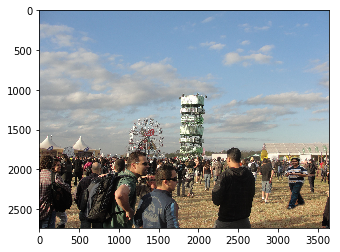

In [6]:
plt.imshow(forged[336])

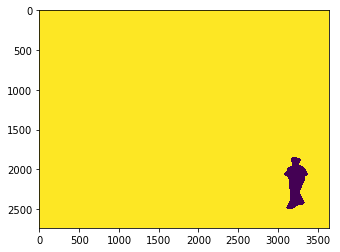

In [7]:
plt.imshow(binaries[336])

In [8]:
len(forged), len(mask), len(pristine)

(450, 450, 1025)

In [ ]:
import time 

start_time = time.time()
samples_fake = []
i = 0 
count = 1 
num_forged = len(forged)

for f, m in zip(forged, binaries):
        
  # print(str(count) + '/' + str(num_forged) +'; time taken: ' + str((time.time() - start_time)))

  print_msg = str(count) + '/' + str(num_forged) +'; time taken: ' + str((time.time() - start_time))
  print(print_msg)
  logging.info(print_msg)
            
  count += 1
    
  img_samples = sample_fake(f, m)
  
  for sample in img_samples:
    samples_fake.append(sample)
    i += 1

1/450; time taken: 0.0003256797790527344
2/450; time taken: 86.27673745155334


In [ ]:

with open('fake_binarie_stride_8_np.pickle', 'wb') as f:
    pickle.dump(np.array(samples_fake), f)

logging.info('pickle dump successful')

In [ ]:
with open('fake_binarie_stride_8_np.pickle', 'rb') as f:
    test = pickle.load(f)

In [ ]:
test


In [ ]:
logging.info('test successful')